In [1808]:
#Tested on Julia 1.5.3

using LinearAlgebra


sigma = 0.09774;
sigma_a = 0.3
delta_t = 1
#Kalman filtering with assumed zero accel, but variance 
#accel is sigma_a^2
#will use Continuous process noise covariance matrix
#Qc
A = [1 0 delta_t 0; 0 1 0 delta_t; 0 0 1 0; 0 0 0 1]
Qc = sigma_a^2*[delta_t^5/20 0 delta_t^4/8 0; 0 delta_t^5/20 0 delta_t^4/8; 0 0 delta_t^3/3 0; 0 0 0 delta_t^3/3]

4×4 Array{Float64,2}:
 0.0045  0.0     0.01125  0.0
 0.0     0.0045  0.0      0.01125
 0.0     0.0     0.03     0.0
 0.0     0.0     0.0      0.03

In [1809]:
# Example with seven cross-fix points
#true position of target
#note zero #acceleration
truex = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
truey = [0.75, 0.6, 0.45, 0.3, 0.15, 0.0, -0.15]

#these are the inverse transformation functions F and G
truetheta1 = pi * (truey .< 0) .+ atan.(truex./truey);
truetheta2 = pi * (truey .> 1) .+ atan.(truex./(1 .- truey))

theta1 = (truetheta1 .+ randn(7)*sigma)
theta2 = (truetheta2 .+ randn(7)*sigma)

#here are the observations x and y
#these are also the transformation functions f and g
x = (sin.(theta1) .* sin.(theta2) ) ./ (sin.(theta1 .+ theta2))
y = (cos.(theta1) .* sin.(theta2) ) ./ (sin.(theta1 .+ theta2));


In [1810]:
#for any observation after #2, directional velocities 
vx = similar(x)
vx[1] = 0
for i in 2:length(x)
     vx[i] = x[i] - x[i-1]
end

vy = similar(y)
vy[1] = 0
for i in 2:length(y)
     vy[i] = y[i] - y[i-1]
end


In [1811]:
#partial derivatives of f and g wrt theta1 and theta2

dfdtheta1 = (1 ./ sin.(theta1 .+ theta2)) .*(sin.(theta2).*cos.(theta1) .- sin.(theta2).*sin.(theta1).*cot.(theta1 .+ theta2))

dfdtheta2 = (1 ./ sin.(theta1 .+ theta2)).*(sin.(theta1).*cos.(theta2) .- sin.(theta2).*sin.(theta1).*cot.(theta1 .+ theta2))

dgdtheta1 = (1 ./ sin.(theta1 .+ theta2)).*(-sin.(theta2).*sin.(theta1) .- sin.(theta2).*cos.(theta1).*cot.(theta1 .+ theta2))

dgdtheta2 = (1 ./ sin.(theta1 .+ theta2)).*(cos.(theta2).*cos.(theta1) .- sin.(theta2).*cos.(theta1).*cot.(theta1 .+ theta2));


In [1812]:
#delta method

varX = (sigma ^ 2) .* (dfdtheta1 .^ 2) .+ (sigma ^ 2) .* (dfdtheta2 .^ 2)
varY = (sigma ^ 2) .* (dgdtheta1 .^ 2) .+ (sigma ^ 2) .* (dgdtheta2 .^ 2)

covXY = (sigma ^ 2) .* (dfdtheta1 .* dgdtheta1) .+ (sigma ^ 2) .* (dfdtheta2 .* dgdtheta2);


In [1813]:
varVx = similar(varX)
varVx[1] = 0
for i in 2:length(varX)
     varVx[i] = varX[i] + varX[i-1]
end

varVy = similar(varY)
varVy[1] = 0
for i in 2:length(varY)
     varVy[i] = varY[i] + varY[i-1]
end


In [1814]:
#Kalman filtering

#initial Kalman state
xk1 = [x[2], y[2], vx[2], vy[2]]

#initial Process Covariance Matrix is initial Sensor Data Error
Pk1 = [varX[2] covXY[2] 0 0; covXY[2] varY[2] 0 0; 0 0 varVx[2] 0; 0 0 0 varVy[2]]

#predicted Kalman state
xkp2 = A*xk1

#predicted Process Covariance Matrix
Pkp2 = A*Pk1*A' + Qc

#setting off-diagonal elements to zero (except 2 and 5)
Pkp2[3] = 0
Pkp2[4] = 0
Pkp2[7] = 0
Pkp2[8] = 0
Pkp2[9] = 0
Pkp2[10] = 0
Pkp2[12] = 0
Pkp2[13] = 0
Pkp2[14] = 0
Pkp2[15] = 0

#Sensor Data Error 
R2 = [varX[3] covXY[3] 0 0; covXY[3] varY[3] 0 0; 0 0 varVx[3] 0; 0 0 0 varVy[3]]

#Kalman Gain
K2 = Pkp2*((Pkp2' + R2)^(-1))

#Observation
yk2 = [x[3], y[3], vx[3], vy[3]]

#Updated Kalman state
xk2 = xkp2 + K2*(yk2 - xkp2);


In [1815]:
#Updated Process Covariance Matrix
Pk2 = (I(4) - K2)*Pkp2*((I(4) - K2)') + K2*R2*K2'

xkp3 = A*xk2
Pkp3 = A*Pk2*A' + Qc
Pkp3[3] = 0
Pkp3[4] = 0
Pkp3[7] = 0
Pkp3[8] = 0
Pkp3[9] = 0
Pkp3[10] = 0
Pkp3[12] = 0
Pkp3[13] = 0
Pkp3[14] = 0
Pkp3[15] = 0
R3 = [varX[4] covXY[4] 0 0; covXY[4] varY[4] 0 0; 0 0 varVx[4] 0; 0 0 0 varVy[4]]
K3 = Pkp3*((Pkp3 + R3)^(-1))
yk3 = [x[4], y[4], vx[4], vy[4]]
xk3 = xkp3 + K3*(yk3 - xkp3);


In [1816]:
Pk3 = (I(4) - K3)*Pkp3*((I(4) - K3)') + K3*R3*K3'

xkp4 = A*xk3
Pkp4 = A*Pk3*A' + Qc
Pkp4[3] = 0
Pkp4[4] = 0
Pkp4[7] = 0
Pkp4[8] = 0
Pkp4[9] = 0
Pkp4[10] = 0
Pkp4[12] = 0
Pkp4[13] = 0
Pkp4[14] = 0
Pkp4[15] = 0
R4 = [varX[5] covXY[5] 0 0; covXY[5] varY[5] 0 0; 0 0 varVx[5] 0; 0 0 0 varVy[5]]
K4 = Pkp4*((Pkp4 + R4)^(-1))
yk4 = [x[5], y[5], vx[5], vy[5]]
xk4 = xkp4 + K4*(yk4 - xkp4);

In [1817]:
Pk4 = (I(4) - K4)*Pkp4*((I(4) - K4)') + K4*R4*K4'

xkp5 = A*xk4
Pkp5 = A*Pk4*A' + Qc
Pkp5[3] = 0
Pkp5[4] = 0
Pkp5[7] = 0
Pkp5[8] = 0
Pkp5[9] = 0
Pkp5[10] = 0
Pkp5[12] = 0
Pkp5[13] = 0
Pkp5[14] = 0
Pkp5[15] = 0
R5 = [varX[6] covXY[6] 0 0; covXY[6] varY[6] 0 0; 0 0 varVx[6] 0; 0 0 0 varVy[6]]
K5 = Pkp5*((Pkp5 + R5)^(-1))
yk5 = [x[6], y[6], vx[6], vy[6]]
xk5 = xkp5 + K5*(yk5 - xkp5);

In [1818]:
Pk5 = (I(4) - K5)*Pkp5*((I(4) - K5)') + K5*R5*K5'

xkp6 = A*xk5
Pkp6 = A*Pk5*A' + Qc
Pkp6[3] = 0
Pkp6[4] = 0
Pkp6[7] = 0
Pkp6[8] = 0
Pkp6[9] = 0
Pkp6[10] = 0
Pkp6[12] = 0
Pkp6[13] = 0
Pkp6[14] = 0
Pkp6[15] = 0
R6 = [varX[7] covXY[7] 0 0; covXY[7] varY[7] 0 0; 0 0 varVx[7] 0; 0 0 0 varVy[7]]
K6 = Pkp6*((Pkp6 + R6)^(-1))
yk6 = [x[7], y[7], vx[7], vy[7]]
xk6 = xkp6 + K6*(yk6 - xkp6);

In [1819]:
Pk6 = (I(4) - K6)*Pkp6*((I(4) - K6)') + K6*R6*K6'

#How to draw 95% confidence error ellipses from 
#a Covariance Matrix?
#drawing two of them, one uses top-left 2x2 submatrix
#of R6: the Blue Ellipse
#the other uses top-left 2x2 submatrix of Pk6: the Green Ellipse

ObsCovMtrx = R6[1:2, 1:2]
KalCovMtrx = Pk6[1:2, 1:2]

Obslambda1 = (tr(ObsCovMtrx) + ((tr(ObsCovMtrx)^2) - 4*det(ObsCovMtrx))^(0.5))/2

Obslambda2 = tr(ObsCovMtrx) - Obslambda1

Kallambda1 = (tr(KalCovMtrx) + ((tr(KalCovMtrx)^2) - 4*det(KalCovMtrx))^(0.5))/2

Kallambda2 = tr(KalCovMtrx) - Kallambda1

Obs_a = (5.991*Obslambda1)^0.5
Obs_b = (5.991*Obslambda2)^0.5
Kal_a = (5.991*Kallambda1)^0.5
Kal_b = (5.991*Kallambda2)^0.5

Obs_alpha = atan(ObsCovMtrx[2]/(Obslambda1 - ObsCovMtrx[4]))
Kal_alpha = atan(KalCovMtrx[2]/(Kallambda1 - KalCovMtrx[4]))
    
ObsEllipseXpoints = x[7] .+ cos(Obs_alpha)*Obs_a*cos.(0:0.01:2*pi) .- sin(Obs_alpha)*Obs_b*sin.(0:0.01:2*pi) 
ObsEllipseYpoints = y[7] .+ sin(Obs_alpha)*Obs_a*cos.(0:0.01:2*pi) .+ cos(Obs_alpha)*Obs_b*sin.(0:0.01:2*pi)

KalEllipseXpoints = xk6[1] .+ cos(Kal_alpha)*Kal_a*cos.(0:0.01:2*pi) .- sin(Kal_alpha)*Kal_b*sin.(0:0.01:2*pi) 
KalEllipseYpoints = xk6[2] .+ sin(Kal_alpha)*Kal_a*cos.(0:0.01:2*pi) .+ cos(Kal_alpha)*Kal_b*sin.(0:0.01:2*pi);

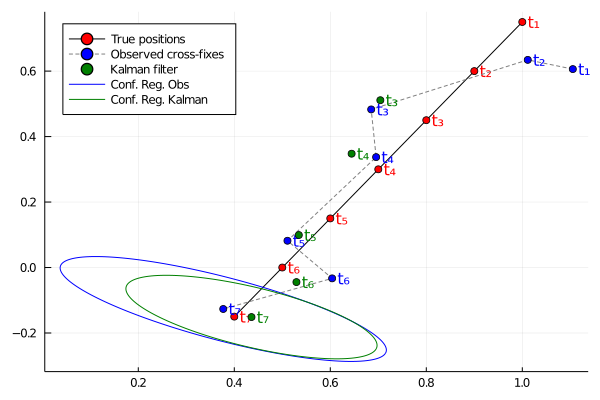

In [1821]:
#import Pkg; Pkg.add("Plots")
using Plots

gr()

plot(truex, truey, series_annotations = text.([" t₁", " t₂", " t₃", " t₄", " t₅", " t₆", " t₇"], 11, :left, :red, :small), markercolor = :red, markershape = :circle, linestyle = :solid, color = :black, label = "True positions")
plot!(x, y, series_annotations = text.([" t₁", " t₂", " t₃", " t₄", " t₅", " t₆", " t₇"], 11, :left, :blue), markercolor = :blue, markershape = :circle, linestyle = :dash, color = "grey", label = "Observed cross-fixes")
scatter!([xk2[1], xk3[1], xk4[1], xk5[1], xk6[1]], [xk2[2], xk3[2], xk4[2], xk5[2], xk6[2]], series_annotations = text.([" t₃", " t₄", " t₅", " t₆", " t₇"], 11, :left, :green), color = :green, label = "Kalman filter") 
#scatter(x, y, smooth=true, linecolor = :grey, linestyle = :dash, color = "blue", label = "Observed cross-fixes")
plot!(ObsEllipseXpoints, ObsEllipseYpoints, color = "blue", label = "Conf. Reg. Obs")
plot!(KalEllipseXpoints, KalEllipseYpoints, color = "green", label = "Conf. Reg. Kalman", legend = :topleft)